In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import mlts

import altair as alt
alt.renderers.enable('notebook')

## Load data

In [2]:
data = mlts.io.merge([
    pd.read_csv('../data/fashion-mnist/fashion-mnist_train.csv'),
    pd.read_csv('../data/fashion-mnist/fashion-mnist_train.csv')
])

In [3]:
mlts.io.check(data)

In [4]:
K = len(data.iloc[:, 0].value_counts())
ds_train, ds_dev, ds_test, mu, sigma = \
    mlts.io.normalize(mlts.io.split(data, ycol=0, shape=(35968), seed=1))

## Implement the model

In [5]:
class ClassificationModel(tf.keras.Model):
    def __init__(self, hparams, K):
        super(ClassificationModel, self).__init__(name='classification')
        
        regularization = None
        if "lambda" in hparams:
            regularization = tf.keras.regularizers.l2(l=hparams["lambda"])
        
        self.l1 = tf.keras.layers.Dense(
            128,
            activation=tf.nn.relu,
            kernel_regularizer=regularization
        )
        self.l2 = tf.keras.layers.Dense(
            K,
            activation=tf.nn.softmax,
            kernel_regularizer=regularization
        )

    def call(self, X):
        A = self.l1(X)
        A = self.l2(A)
        return A

In [6]:
class FasionMNISTAdapter(mlts.tf.ModelAdapter):
    def __init__(self, *args, **kwargs):
        super(FasionMNISTAdapter, self).__init__(*args, **kwargs)

    @staticmethod
    def build_model(hparams, metrics = []):
        model = ClassificationModel(hparams=hparams, K=10)
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=metrics,
        )
        
        return model
    
    @staticmethod
    def estimate_parameters(options, model, ds, callbacks=[]):
        X, y = ds
        
        mlts.tf.ModelAdapter.verify_options(options)
        if options["seed"] != None: tf.random.set_seed(options["seed"])
        model.fit(
            tf.data.Dataset.from_tensor_slices(ds).batch(options["batch_size"]),
            epochs=options["epochs"],
            shuffle=False,
            callbacks=callbacks,
            verbose=options["verbose"],
        )
        
        return model

## Analyze the dataset

In [7]:
ad = FasionMNISTAdapter({"epochs": 5, "seed": 1})
m_hist = ad.analyze_dataset(ds_train, ds_dev)

W0805 12:36:39.135201 4352738752 deprecation.py:323] From /Users/manifest/projects/github/machine-learning-notebook/venv/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


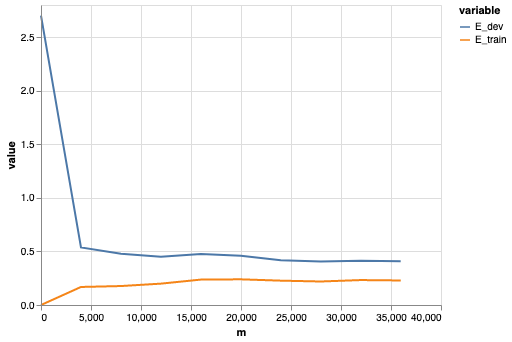

In [8]:
alt.Chart(m_hist.melt(id_vars='m')).mark_line().encode(
    x = 'm',
    y = 'value',
    color = 'variable'
)

## Evaluate the model

In [9]:
ad = FasionMNISTAdapter({"epochs": 5, "seed": 1}, metrics=["accuracy"])
ad.fit(ds_train)

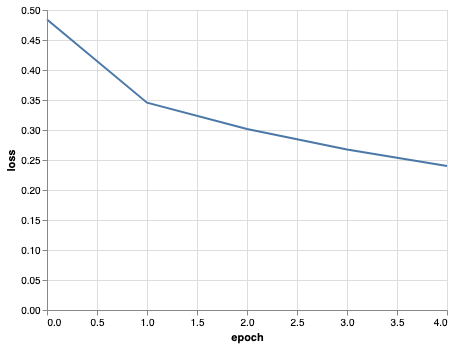

In [10]:
alt.Chart(ad.metrics_history().reset_index()).mark_line().encode(
    x = 'epoch',
    y = 'loss',
)

In [11]:
E_train = ad.metric("loss")
Acc_train = ad.metric("accuracy")
E_dev, Acc_dev = ad.evaluate(ds_dev)
E_test, Acc_test = ad.evaluate(ds_test)

print("Set error\n  training: {:9.2f}\n  development: {:9.2f}\n  testing: {:9.2f}"
      .format(E_train, E_dev, E_test))

print("Accuracy\n  training: {:1.2f}\n  development: {:1.2f}\n  testing: {:1.2f}"
      .format(Acc_train, Acc_dev, Acc_test))

Set error
  training:      0.24
  development:      0.41
  testing:      0.40
Accuracy
  training: 0.91
  development: 0.87
  testing: 0.87


## Tune hyperparameters

In [12]:
ad = FasionMNISTAdapter({"epochs": 5, "seed": 1})
_, lambda_hist = ad.tune_hyperparameters(
    mlts.tf.LambdaRangeGenerator(start=0.00001, stop=0.1),
    mlts.io.slice(ds_train, 0, 1024),
    ds_dev,
)

In [13]:
ad.hparams["lambda"]

0.018447926383173302

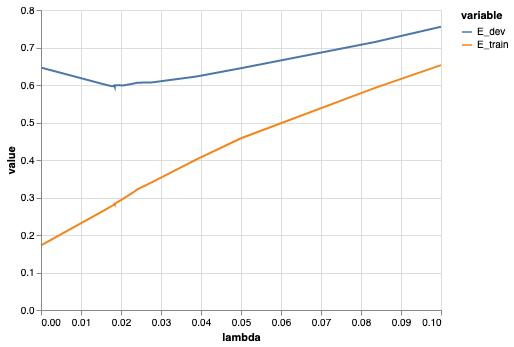

In [14]:
alt.Chart(lambda_hist.melt(id_vars='lambda')).mark_line().encode(
    x = 'lambda',
    y = 'value',
    color = 'variable'
)

## Estimate the generalized error

In [15]:
ad = FasionMNISTAdapter({"epochs": 10, "seed": 1}, hparams=ad.hparams, metrics=["accuracy"])

In [16]:
m_hist = ad.analyze_dataset(ds_train, ds_dev)

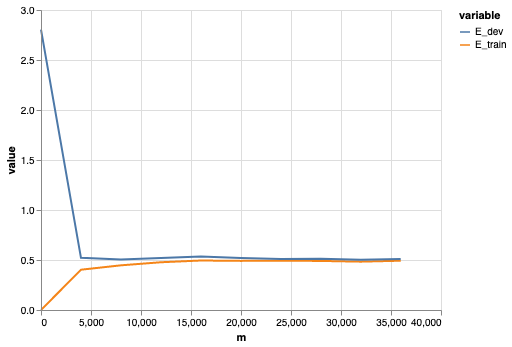

In [17]:
alt.Chart(m_hist.melt(id_vars='m')).mark_line().encode(
    x = 'm',
    y = 'value',
    color = 'variable'
)

In [18]:
ad.fit(ds_train)

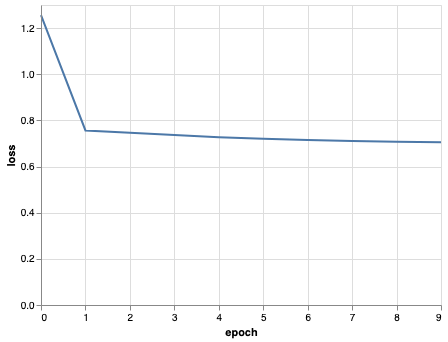

In [19]:
alt.Chart(ad.metrics_history().reset_index()).mark_line().encode(
    x = 'epoch',
    y = 'loss',
)

In [20]:
E_train = ad.metric("loss")
Acc_train = ad.metric("accuracy")
E_dev, Acc_dev = ad.evaluate(ds_dev)
E_test, Acc_test = ad.evaluate(ds_test)

print("Set error\n  training: {:9.2f}\n  development: {:9.2f}\n  testing: {:9.2f}"
      .format(E_train, E_dev, E_test))

print("Accuracy\n  training: {:1.2f}\n  development: {:1.2f}\n  testing: {:1.2f}"
      .format(Acc_train, Acc_dev, Acc_test))

Set error
  training:      0.71
  development:      0.71
  testing:      0.72
Accuracy
  training: 0.83
  development: 0.81
  testing: 0.81
